<a href="https://colab.research.google.com/github/BeardedBaldo/BasicConvnet_Pytorch/blob/main/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import tarfile
import os
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
## download stanford dog dataset
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
r = requests.get(url, allow_redirects = True) 
open("images.tar", "wb").write(r.content)

793579520

In [4]:
### untaring the dataset
tar = tarfile.open("images.tar")
tar.extractall("./")
tar.close()

In [3]:
### check for gpus and assign to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
### image loader function and transform object

imageSize = (224, 224) if torch.cuda.is_available() else (128, 128)

loader = transforms.Compose([transforms.Resize(imageSize), 
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406),
                                                  (0.229, 0.224, 0.225))
                             ])

def imageLoader(imagePath):
  image = Image.open(imagePath)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)


In [5]:
samplePath = './Images/n02085620-Chihuahua/n02085620_10074.jpg'

sampleImage = imageLoader(samplePath)

print(type(sampleImage))
print(sampleImage.size())

<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])


In [29]:
### variable initialization
dataDir = "./Images"
testSplit = 0.2
valSplit = 0.2
epochs = 15
featureExtract = True
modelName = "vgg11"

In [7]:
### load data and split into train and test

## delete 2933 from Shetland sheeps since its a png

dataDict = {"train": {
    "images": [],
    "labels": []
}, "validation": {
    "images": [],
    "labels": []    
}}
trainLabels = []
trainImages = []
mapping = []
testLabels = []
testImages = []

sampleList = ['./Images/n02108000-EntleBucher', './Images/n02111889-Samoyed']

for i, (root, dirs, files) in enumerate(os.walk(dataDir)):
  if root != dataDir and i<80:# and root in sampleList:    ### add root in sampleList condition only for testing
    name = root.split("/")[-1].split("-")[-1]
    mapping.append(name)
    print(root)
    print(name, " : ", i)
    nFiles = len(files)
    for j, f in enumerate(files):
      filePath = os.path.join(root, f)
      image = imageLoader(filePath)
      if j < (nFiles * (1 - testSplit)):
        trainImages.append(image)
        trainLabels.append(i-1)
      else:
        testImages.append(image)
        testLabels.append(i-1)
      del image

trainData = {}
trainData["trainImages"] = trainImages
trainData["trainLabels"] = trainLabels
nClasses = len(mapping)
    
print(trainData.keys())

./Images/n02108422-bull_mastiff
bull_mastiff  :  1
./Images/n02113978-Mexican_hairless
Mexican_hairless  :  2
./Images/n02087046-toy_terrier
toy_terrier  :  3
./Images/n02085936-Maltese_dog
Maltese_dog  :  4
./Images/n02098286-West_Highland_white_terrier
West_Highland_white_terrier  :  5
./Images/n02089973-English_foxhound
English_foxhound  :  6
./Images/n02111889-Samoyed
Samoyed  :  7
./Images/n02097047-miniature_schnauzer
miniature_schnauzer  :  8
./Images/n02093991-Irish_terrier
Irish_terrier  :  9
./Images/n02094433-Yorkshire_terrier
Yorkshire_terrier  :  10
./Images/n02097209-standard_schnauzer
standard_schnauzer  :  11
./Images/n02098413-Lhasa
Lhasa  :  12
./Images/n02096585-Boston_bull
Boston_bull  :  13
./Images/n02113624-toy_poodle
toy_poodle  :  14
./Images/n02100236-German_short-haired_pointer
haired_pointer  :  15
./Images/n02105251-briard
briard  :  16
./Images/n02110958-pug
pug  :  17
./Images/n02113712-miniature_poodle
miniature_poodle  :  18
./Images/n02094114-Norfolk_t

In [8]:
### train validation split 
trainImages, validationImages, trainLabels, validationLabels = train_test_split(trainImages, trainLabels, test_size = valSplit)
dataDict["train"]["images"] = trainImages
dataDict["validation"]["images"] = validationImages
dataDict["train"]["labels"] = trainLabels
dataDict["validation"]["labels"] = validationLabels

In [19]:
### set requires_grad for model parameters

def setParameterRequiresGrad(model, featureExract):
  if featureExtract:
    for param in model.parameters():
      param.requires_grad = False

In [30]:
### model initialization

def initializeModel(modelName, nClasses, featureExtract, 
                    use_pretrained = True):
  modelFt = None
  inputSize = 0

  if modelName == "resnet":
    modelFt = models.resnet50(pretrained = use_pretrained)
    setParameterRequiresGrad(modelFt, featureExtract)
    nFeatures = modelFt.fc.in_features
    modelFt.fc = nn.Linear(nFeatures, nClasses)
    inputSize = 224

  elif modelName == "vgg11":
    modelFt = models.vgg11_bn(pretrained=use_pretrained)
    setParameterRequiresGrad(modelFt, featureExtract)
    nFeatures = modelFt.classifier[6].in_features
    modelFt.classifier[6] = nn.Linear(nFeatures, nClasses)
    inputSize = 224

  elif modelName == "inception":
    modelFt = models.inception_v3(pretrained = use_pretrained)
    setParameterRequiresGrad(modelFt, featureExtract)
    nFeatures = modelFt.AuxLogits.fc.in_features
    modelFt.AuxLogits.fc = nn.Linear(nFeatures, nClasses)
    nFeatures = modelFt.fc.in_features
    modelFt.fc = nn.Linear(nFeatures, nClasses)
    inputSize = 299

  else:
    print("Invalid model name, exiting...")
    exit()

  return modelFt, inputSize 

modelFt, inputSize = initializeModel(modelName, nClasses,
                                     featureExtract)
print(modelFt)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [31]:
### model GPU initialization, optimizer initialization

## send model to GPU
modelFt = modelFt.to(device)


## print parameters to learn
print("Parameters to learn")
if featureExtract:
  paramsUpdate = []
  for name, param in modelFt.named_parameters():
    if param.requires_grad == True:
      paramsUpdate.append(param)
      print("\t", name)
else:
  paramsUpdate = modelFt.parameters()
  for name, param in modelFt.named_parameters():
    if param.requires_grad == True:
      print("\t", name)


## initialize optimizer
optimizerFt = optim.Adam(paramsUpdate, lr = 0.001) 

Parameters to learn
	 classifier.6.weight
	 classifier.6.bias


In [32]:
### model training function

def trainModel(model, trainData, criterion, optimizer,
               nEpochs = 10, isInception = False):
  start = time.time()

  trainAccHistory = []
  valAccHistory = []

  bestModelWts = copy.deepcopy(model.state_dict())
  bestAcc = 0

  for epoch in range(nEpochs):
    print(f'Epoch {epoch}/{nEpochs - 1}')
    print('-' * 10)

    for phase in dataDict.keys():
      if phase == "train":
        model.train()
      else:
        model.eval()

      runningLoss = 0.0
      runningCorrects = 0

      inputs = dataDict[phase]["images"]
      labels = dataDict[phase]["labels"]

      for i, input in enumerate(inputs):
        input = input.to(device)
        label = []
        label.append(labels[i])
        label = torch.tensor(np.array(label)).to(device)
        
        ##zero gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):

          if isInception:
            output, auxOutput = model(input)
            mainLoss = criterion(output, label)
            auxLoss = criterion(auxOutput, label)
            loss = mainLoss + 0.4 * auxLoss
          else:
            output = model(input)
            loss = criterion(output, label)

          _, prediction = torch.max(output, 1)

          if phase == "train":
            loss.backward()
            optimizer.step()

        runningLoss += loss.item() * input.size(0)
        runningCorrects += torch.sum(prediction == label)

      epochLoss = runningLoss / (len(inputs))
      epochAcc = runningCorrects.double() / (len(inputs))
      
      print("{} loss: {:4f}, {} accuracy: {:4f}".format(phase,
                                                        epochLoss,
                                                        phase,
                                                        epochAcc))
      if phase == "train":
        trainAccHistory.append(epochAcc)
      else:
        valAccHistory.append(epochAcc)

      if phase == "validation" and epochAcc > bestAcc:
        bestAcc = epochAcc
        bestModelWts = copy.deepcopy(model.state_dict())
      

      

  timeTaken = time.time() - start
  print("training complete in {:.0f}m {:.0f}s".format(timeTaken // 60,
                                         timeTaken % 60))
  
  print("Best validation accuracy: {:4f}".format(bestAcc))

  model.load_state_dict(bestModelWts)

  return model, trainAccHistory, valAccHistory




In [33]:
criterion = nn.CrossEntropyLoss()

modelFt, trainhist, valHist = trainModel(modelFt, trainData, criterion,
                           optimizerFt, nEpochs = epochs,
                           isInception = (modelName == "inception"))

Epoch 0/14
----------
train loss: 4.534700, train accuracy: 0.170806
validation loss: 2.034903, validation accuracy: 0.653864
Epoch 1/14
----------
train loss: 4.244231, train accuracy: 0.277648
validation loss: 2.453505, validation accuracy: 0.666042
Epoch 2/14
----------
train loss: 4.311552, train accuracy: 0.313964
validation loss: 2.696318, validation accuracy: 0.675878
Epoch 3/14
----------
train loss: 4.412449, train accuracy: 0.336692
validation loss: 2.829746, validation accuracy: 0.688993
Epoch 4/14
----------
train loss: 4.453139, train accuracy: 0.349930
validation loss: 3.262480, validation accuracy: 0.678220
Epoch 5/14
----------
train loss: 4.646470, train accuracy: 0.360005
validation loss: 3.353479, validation accuracy: 0.671194
Epoch 6/14
----------
train loss: 4.624108, train accuracy: 0.374297
validation loss: 3.533420, validation accuracy: 0.678220
Epoch 7/14
----------
train loss: 4.706920, train accuracy: 0.385309
validation loss: 3.727799, validation accuracy: 0

No handles with labels found to put in legend.


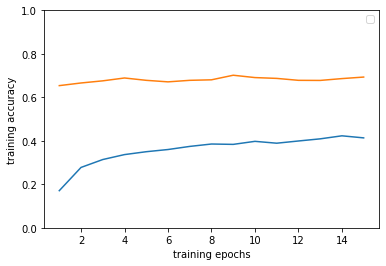

In [42]:
###
tHist = [h.cpu().numpy() for h in trainhist]
vHist = [h.cpu().numpy() for h in valHist]

plt.xlabel("training epochs")
plt.ylabel("training accuracy")
plt.plot(range(1, epochs+1), tHist)
plt.plot(range(1, epochs+1), vHist)
plt.ylim((0, 1.))
plt.legend()
plt.show()

In [35]:
### model evaluation

total = 0
correct = 0

with torch.no_grad():
  modelFt.eval()
  inputs = testImages
  labels = testLabels
  for i, input in enumerate(inputs):
      input = input.to(device)
      label = []
      label.append(labels[i])
      label = torch.tensor(np.array(label)).to(device)
      output = modelFt(input)
      _, predicted = torch.max(output, 1)
      #print("Label:", int(label[0]), ", Predicted:", int(predicted[0]))
      total += label.size(0)
      correct += (predicted==label).sum().item()

print("Testing accuracy: ", (correct/total) * 100)


Testing accuracy:  69.56686930091185


In [38]:
### prediction 
predictPath = "./Images/n02086240-Shih-Tzu/n02086240_1011.jpg"

def predictBreed(predictPath, model, mapping):
  input = imageLoader(predictPath)
  with torch.no_grad():
    input = input.to(device)
    output = model(input)
    _, predicted = torch.max(output, 1)
    predictedLabel = int(predicted[0])
    predictedBreed = mapping[predictedLabel]

  return predictedBreed

predictBreed = predictBreed(predictPath, modelFt, mapping)



In [39]:
print(predictBreed)

Tzu
